In [1]:
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import astropy.constants as const
import scipy
from matplotlib import gridspec
from astropy.io import fits
import pickle
from pickle import *
import time
import math
import re
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize
from astropy.table import Table
import itertools
from scipy.interpolate import interp1d
from scipy.integrate  import trapz

# Nenkova et al. (2008) model

According to *The Astrophysical Journal, 685(1), 160* the free parameters of the model are: $Y$, $\mathcal{N}_o$, $q$, $\tau_v$, $\sigma$ y $i$.

In [2]:
npzfile = np.load('Models/nenkova_v0_files.npz')  
print(type(npzfile))
print(npzfile.files)  # List of files that contain the following data: wavelength, SED and parameters

<class 'numpy.lib.npyio.NpzFile'>
['arr_1', 'arr_0', 'arr_2']


Now, we print each file to identify it.

In [3]:
npzfile['arr_0'] #Observation angle

array([10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [4]:
npzfile['arr_1'] #Log(nu)

array([[11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       ...,
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768]])

In [5]:
npzfile['arr_2'] # SED

array([[2.52925073e-73, 1.22105908e-72, 5.68080811e-72, ...,
        1.21524045e-72, 8.10714442e-73, 4.74898149e-73],
       [2.53057801e-73, 1.22177283e-72, 5.68740672e-72, ...,
        1.19830533e-72, 7.99963317e-73, 4.70119967e-73],
       [2.53363073e-73, 1.22293269e-72, 5.69040609e-72, ...,
        1.14399617e-72, 7.63728045e-73, 4.49945423e-73],
       ...,
       [2.53628528e-73, 1.22275425e-72, 5.68200785e-72, ...,
        5.55646942e-73, 3.69420591e-73, 2.11699985e-73],
       [2.53588710e-73, 1.22230815e-72, 5.67600911e-72, ...,
        4.33188546e-73, 2.87970867e-73, 1.64794170e-73],
       [2.53535619e-73, 1.22177283e-72, 5.67360962e-72, ...,
        3.99259920e-73, 2.65154591e-73, 1.51601080e-73]])

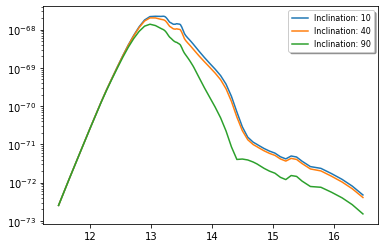

In [6]:
plt.semilogy(npzfile['arr_1'][0], npzfile['arr_2'][0], label = 'Inclination: 10')
plt.semilogy(npzfile['arr_1'][3], npzfile['arr_2'][3], label = 'Inclination: 40')
plt.semilogy(npzfile['arr_1'][8], npzfile['arr_2'][8], label = 'Inclination: 90')
plt.legend(fontsize = 8, shadow = True)

In [7]:
#write the pickle file with the dictionary
incl, torus_wv, torus_SED = npzfile['arr_0'], npzfile['arr_1'], npzfile['arr_2']
NK0 = {'SED' : torus_SED, 'wavelength' : torus_wv, 'incl-values' : incl}
f1 = open('Models/nenkova_v0.pickle', 'wb')
pickle.dump(NK0, f1, protocol=2)
f1.close()


In [8]:
NK0dict = pickle.load(open('Models/nenkova_v0.pickle', 'rb'), encoding='latin1')  
NK0dict

{'SED': array([[2.52925073e-73, 1.22105908e-72, 5.68080811e-72, ...,
         1.21524045e-72, 8.10714442e-73, 4.74898149e-73],
        [2.53057801e-73, 1.22177283e-72, 5.68740672e-72, ...,
         1.19830533e-72, 7.99963317e-73, 4.70119967e-73],
        [2.53363073e-73, 1.22293269e-72, 5.69040609e-72, ...,
         1.14399617e-72, 7.63728045e-73, 4.49945423e-73],
        ...,
        [2.53628528e-73, 1.22275425e-72, 5.68200785e-72, ...,
         5.55646942e-73, 3.69420591e-73, 2.11699985e-73],
        [2.53588710e-73, 1.22230815e-72, 5.67600911e-72, ...,
         4.33188546e-73, 2.87970867e-73, 1.64794170e-73],
        [2.53535619e-73, 1.22177283e-72, 5.67360962e-72, ...,
         3.99259920e-73, 2.65154591e-73, 1.51601080e-73]]),
 'wavelength': array([[11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
        [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
        [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
        ...,
        [11.4768, 11.649

# SKIRTOR

https://sites.google.com/site/skirtorus/sed-library

(1e-17, 1e-10)

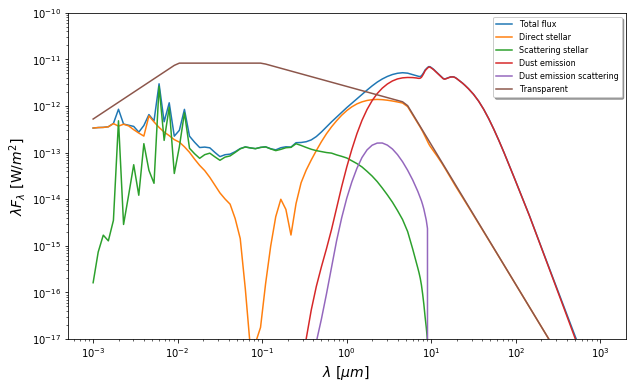

In [2]:
SED = pd.read_csv("Models/SKIRTOR/skirtor_2016-7-18/t3_p0_q0.5_oa40_R10_Mcl0.97_i50_sed.dat", delim_whitespace=True, decimal=".", names= ['wl', 'TwlFwl', 'DSwlFwl', 'SSwlFwl', 'TDwlFwl', 'SDwlFwl', 'TrwlFwl'], skiprows = 7)
c = 2.997e8    #m/s
wl = SED.iloc[:, 0]*1e-6  #m
nu = c/wl  #Hz
nu = nu[::-1]
log_nu = np.log10(nu)

d = 3.086*1e22 # 10 Mpc in m just information
F_l = SED.iloc[:, 4]/wl
F_nu = (F_l*wl**2)/c  #W/m²Hz 
F_nu = F_nu[::-1]
F_nu2 = F_nu/(4*np.pi*d**2)  # just scale factor

fig = plt.figure(figsize=(10, 6))
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 1], label = 'Total flux')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 2], label = 'Direct stellar')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 3], label = 'Scattering stellar')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 4], label = 'Dust emission')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 5], label = 'Dust emission scattering')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 6], label = 'Transparent')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'$\lambda$ [$\mu m$] ', fontsize = 14) 
plt.ylabel(r'$\lambda F_\lambda$ [W/$m^2$] ', fontsize = 14) 
plt.ylim(1e-17, 1e-10)

(1e-10, 1e-05)

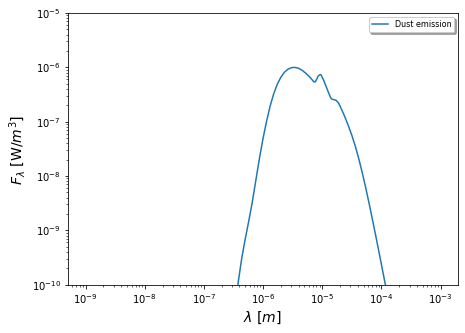

In [10]:
fig = plt.figure(figsize=(7, 5))
plt.loglog(wl, SED.iloc[:, 4]/wl, label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'$\lambda$ [$m$] ', fontsize = 14) 
plt.ylabel(r'$F_\lambda$ [W/$m^3$] ', fontsize = 14) 
plt.ylim(1e-10, 1e-5)

(1e-17, 1e-10)

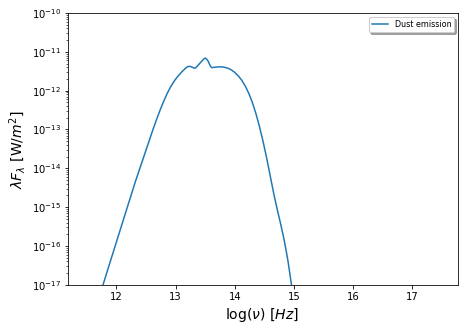

In [11]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, SED.iloc[:, 4][::-1], label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\lambda F_\lambda$ [W/$m^2$] ', fontsize = 14) 
plt.ylim(1e-17, 1e-10)

(1e-18, 1e-10)

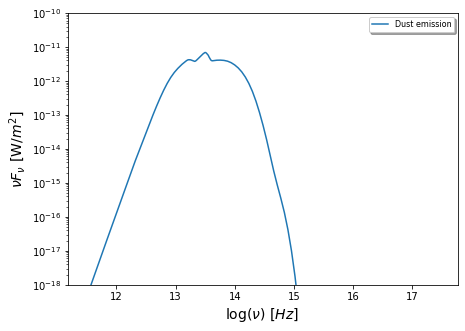

In [12]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, (nu*F_nu), label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [W/$m^2$] ', fontsize = 14) 
plt.ylim(1e-18, 1e-10)

(1e-76, 1e-70)

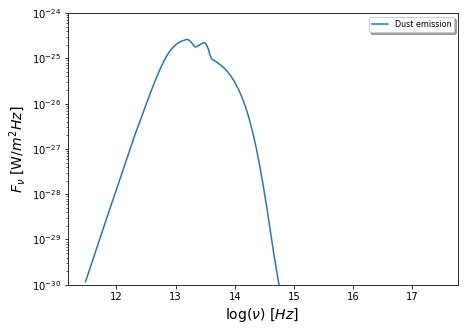

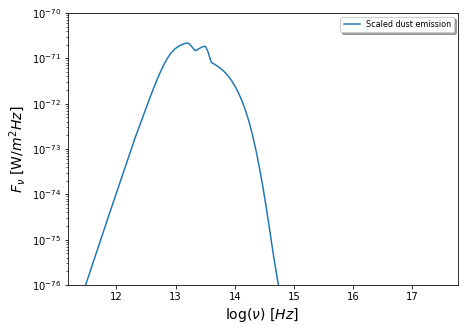

In [4]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, F_nu, label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-30, 1e-24)
#plt.ylim(1e-10, 1e-4)

fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, F_nu2, label = 'Scaled dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-76, 1e-70)

In [15]:
DustM = pd.read_csv("Models/SKIRTOR/total_dust_mass_2016-7-18.txt", sep = '    ', decimal=".", names= ['model', 'Mass'], skiprows = 2, engine = 'python')

In [16]:
nombre = 't3_p0_q0.5_oa40_R10_Mcl0.97_i50_sed.dat'

#A way to split the string a read the information about each SED
sep = [m.start() for m in re.finditer('_', nombre)]
print(nombre[nombre.find('t')+1: sep[0]])
print(nombre[nombre.find('p')+1: sep[1]])
print(nombre[nombre.find('q')+1: sep[2]])
print(nombre[nombre.find('oa')+2: sep[3]])
print(nombre[nombre.find('R')+1: sep[4]])
print(nombre[nombre.find('Mcl')+3: sep[5]])
print(nombre[nombre.find('i')+1: sep[6]])
print(nombre[: sep[5]])
print(DustM[DustM['model'] == nombre[: sep[5]]]['Mass'])

3
0
0.5
40
10
0.97
50
t3_p0_q0.5_oa40_R10_Mcl0.97
489    419.004 Msun
Name: Mass, dtype: object


In [13]:
# It's necessary to obtaine the value (str) and transform it into float
float(DustM[DustM['model'] == nombre[: sep[5]]]['Mass'].values.item()[:-5])

419.004

In [109]:
#Code to create the dictionary with all the information of each SED
column_names = ["wavelength", 'SED', 'tv-values', 'p-values', 'q-values', 'oa-values', 'r-values', 'mcl-values', 'incl-values', 'Dm-values']  #To create the columns of the dataframe
SKIRTOR = pd.DataFrame(columns = column_names)
DustM = pd.read_csv("Models/SKIRTOR/total_dust_mass_2016-7-18.txt", sep = '    ', decimal=".", names= ['model', 'Mass'], skiprows = 2, engine = 'python')
j = 0

for i in os.listdir("Models/SKIRTOR/prueba"):
    data = pd.read_csv("Models/SKIRTOR/prueba/" + i, delim_whitespace=True, decimal=".", names= ['wl', 'TwlFwl', 'DSwlFwl', 'SSwlFwl', 'TDwlFwl', 'SDwlFwl', 'TrwlFwl'], skiprows = 7)
    
    c = 2.997e8
    log_nu = np.log10(c/(data.iloc[:, 0]*1e-6))
    log_nu = log_nu[::-1]

    d = 3.086*1e25 # 10 Mpc
    F_l = data.iloc[:, 4]/(data.iloc[:, 0]*4*np.pi*d**2)
    F_nu = F_l[::-1]
    
    sep = [m.start() for m in re.finditer('_', i)]
    tv = float(i[i.find('t')+1: sep[0]])
    p = float(i[i.find('p')+1: sep[1]])
    q = float(i[i.find('q')+1: sep[2]])
    oa = float(i[i.find('oa')+2: sep[3]])
    r = float(i[i.find('R')+1: sep[4]])
    mcl = float(i[i.find('Mcl')+3: sep[5]])
    incl = float(i[i.find('i')+1: sep[6]])
    Md = float(DustM[DustM['model'] == i[: sep[5]]]['Mass'].values.item()[:-5])
    
    New_row = {'SED': F_nu, 'wavelength': log_nu, 'tv-values': tv, 'p-values': p, 'q-values': q, 'oa-values': oa, 'r-values': r, 'mcl-values': mcl, 'incl-values': incl, 'Dm-values': Md} 
    SKIRTOR = SKIRTOR.append(New_row, ignore_index = True) 
    j += 1
    if j == 3840:
        print('20$\%$ of the finished process...')
    elif j == 7680:
        print('40$\%$ of the finished process...')
    elif j == 11520:
        print('60$\%$ of the finished process...')
    elif j == 15360:
        print('80$\%$ of the finished process...')
    elif j == 19199:
        print('Completed process.')

In [110]:
SKIRTOR

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
0,131 11.476687 130 11.536687 129 11.59...,131 2.321010e-74 130 5.244959e-74 129 ...,3.0,0.5,0.5,20.0,20.0,0.97,10.0,662.1960
1,131 11.476687 130 11.536687 129 11.59...,131 2.320947e-74 130 5.244773e-74 129 ...,3.0,0.5,0.5,20.0,20.0,0.97,50.0,662.1960
2,131 11.476687 130 11.536687 129 11.59...,131 8.852830e-75 130 2.006639e-74 129 ...,3.0,0.5,0.5,20.0,10.0,0.97,30.0,187.6690
3,131 11.476687 130 11.536687 129 11.59...,131 1.603092e-74 130 3.600531e-74 129 ...,3.0,0.5,0.5,10.0,30.0,0.97,60.0,738.7750
4,131 11.476687 130 11.536687 129 11.59...,131 8.644745e-75 130 1.946334e-74 129 ...,3.0,0.5,0.5,10.0,20.0,0.97,40.0,345.4870
5,131 11.476687 130 11.536687 129 11.59...,131 3.091124e-75 130 6.987020e-75 129 ...,3.0,0.5,0.5,10.0,10.0,0.97,0.0,98.0076
6,131 11.476687 130 11.536687 129 11.59...,131 1.603115e-74 130 3.600600e-74 129 ...,3.0,0.5,0.5,10.0,30.0,0.97,50.0,738.7750
7,131 11.476687 130 11.536687 129 11.59...,131 8.852628e-75 130 2.006578e-74 129 ...,3.0,0.5,0.5,20.0,10.0,0.97,50.0,187.6690
8,131 11.476687 130 11.536687 129 11.59...,131 1.603139e-74 130 3.600670e-74 129 ...,3.0,0.5,0.5,10.0,30.0,0.97,30.0,738.7750
9,131 11.476687 130 11.536687 129 11.59...,131 8.851937e-75 130 2.006372e-74 129 ...,3.0,0.5,0.5,20.0,10.0,0.97,70.0,187.6690


In [43]:
SKIRTORdict = pickle.load(open('Models/SKIRTOR.pickle', 'rb'), encoding='latin1')  
SKIRTORdict

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
0,131 11.476687 130 11.536687 129 11.59...,131 4.916406e-76 130 8.469030e-76 129 ...,5.0,1.0,0.5,70.0,20.0,0.97,80.0,1722.370
1,131 11.476687 130 11.536687 129 11.59...,131 2.626583e-76 130 4.517134e-76 129 ...,11.0,0.0,0.0,30.0,10.0,0.97,30.0,1393.130
2,131 11.476687 130 11.536687 129 11.59...,131 3.780430e-76 130 6.486721e-76 129 ...,9.0,0.0,1.5,30.0,20.0,0.97,20.0,3046.850
3,131 11.476687 130 11.536687 129 11.59...,131 4.705114e-76 130 8.100102e-76 129 ...,5.0,1.5,0.5,70.0,30.0,0.97,0.0,1723.650
4,131 11.476687 130 11.536687 129 11.59...,131 9.744822e-77 130 1.679536e-76 129 ...,3.0,0.0,0.5,40.0,10.0,0.97,50.0,419.004
...,...,...,...,...,...,...,...,...,...,...
19195,131 11.476687 130 11.536687 129 11.59...,131 3.230850e-76 130 5.568634e-76 129 ...,9.0,0.0,1.0,50.0,10.0,0.97,50.0,1225.920
19196,131 11.476687 130 11.536687 129 11.59...,131 9.244661e-77 130 1.585096e-76 129 ...,3.0,0.0,1.0,20.0,20.0,0.97,50.0,832.003
19197,131 11.476687 130 11.536687 129 11.59...,131 8.716065e-76 130 1.503236e-75 129 ...,11.0,0.0,0.5,80.0,10.0,0.97,20.0,2180.960
19198,131 11.476687 130 11.536687 129 11.59...,131 1.041018e-76 130 1.768757e-76 129 ...,7.0,0.5,1.0,10.0,30.0,0.97,0.0,1653.870


(1e-76, 1e-69)

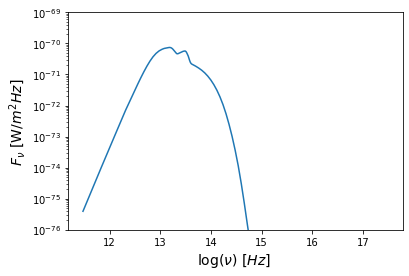

In [46]:
plt.semilogy(SKIRTORdict['wavelength'].iloc[1000], SKIRTORdict['SED'].iloc[1000])
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-76, 1e-69)

In [4]:
SKIRTORdict['oa-values'].unique()

array([70., 30., 40., 80., 50., 20., 60., 10.])

In [5]:
SKIRTORdict['tv-values'].unique()

array([ 5., 11.,  9.,  3.,  7.])

In [28]:
SKIRTORdict['p-values'].unique()

array([1. , 0. , 1.5, 0.5])

In [27]:
int_par, dec_par = divmod(15, 8)

print(int_par*10)
print(dec_par*10+10)

10
80


In [15]:
int_part5, dec_part5 = divmod(41, 5)
int_part8, dec_part8 = divmod(int_part5 , 8)

print(int_part8*10)
print(dec_part8*10 + 10)
print(dec_part5*2 +3)

10
10
5


In [41]:
int_part4, dec_part4 = divmod(164, 4)
int_part5, dec_part5 = divmod(int_part4, 5)
int_part8, dec_part8 = divmod(int_part5 , 8)

print(int_part8*10)
print(dec_part8*10 + 10)
print(dec_part5*2 +3)
print(dec_part4/2)

10
10
5
0.0


In [19]:
import itertools

#itertools let us to create a parameters combinatorial, it's used in MODEL_AGNfitter.py
idxs = [np.array([1,2,3]), np.array([3,5]), np.array([1,7])]
par_idxs_combinations = np.array(list(itertools.product(*idxs)))
par_idxs_combinations

array([[1, 3, 1],
       [1, 3, 7],
       [1, 5, 1],
       [1, 5, 7],
       [2, 3, 1],
       [2, 3, 7],
       [2, 5, 1],
       [2, 5, 7],
       [3, 3, 1],
       [3, 3, 7],
       [3, 5, 1],
       [3, 5, 7]])

In [20]:
#Filtering test
prueba1 = SKIRTORdict[(SKIRTORdict['tv-values'] == 3) & (SKIRTORdict['p-values'] == 0)& (SKIRTORdict['q-values'] == 0.5)& (SKIRTORdict['oa-values'] == 40) & (SKIRTORdict['r-values'] == 10) & (SKIRTORdict['mcl-values'] == 0.97) & (SKIRTORdict['incl-values'] == 50)]
prueba1

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
4,131 11.476687 130 11.536687 129 11.59...,131 2.920523e-74 130 6.635538e-74 129 ...,3.0,0.0,0.5,40.0,10.0,0.97,50.0,419.004


In [21]:
# .values.item().to_numpy() let us to transform a pandas series to a numpy array (needed in MODEL_AGNfitter.py)
tor_nu0, tor_Fnu0 =  prueba1['wavelength'].values.item().to_numpy(),prueba1['SED'].values.item().to_numpy()
tor_nu0, tor_Fnu0

(array([11.47668674, 11.53668674, 11.59668674, 11.65668674, 11.71668674,
        11.77668674, 11.83668674, 11.89668674, 11.95668674, 12.01668674,
        12.07668674, 12.13668674, 12.19668674, 12.25668674, 12.31668674,
        12.37668674, 12.43668674, 12.49668674, 12.55668674, 12.61668674,
        12.67668674, 12.73668674, 12.79668674, 12.85668674, 12.91668674,
        12.97668674, 13.03668674, 13.07874673, 13.09304336, 13.10734   ,
        13.12163662, 13.13593325, 13.15022988, 13.16452652, 13.17882314,
        13.19311978, 13.20741641, 13.22171304, 13.23600967, 13.2503063 ,
        13.26460293, 13.27889956, 13.29319619, 13.30749282, 13.32178945,
        13.33608608, 13.35038271, 13.36467934, 13.37897597, 13.3932726 ,
        13.40756923, 13.42186586, 13.43616249, 13.45045912, 13.46475575,
        13.47905238, 13.49334901, 13.50764564, 13.52194227, 13.5362389 ,
        13.55053553, 13.56483216, 13.57912879, 13.59342542, 13.60772205,
        13.62201868, 13.63631531, 13.65061194, 13.6

In [22]:
SKIRTORCdict = pickle.load(open('Models/SKIRTOR_CIGALE.pickle', 'rb'), encoding='latin1')  
SKIRTORCdict = SKIRTORCdict.sort_values('incl-values', ascending=True)
SKIRTORCdict

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
6,131 11.476687 130 11.536687 129 11.59...,131 2.722766e-76 130 4.681085e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,0.0,1520.55
2,131 11.476687 130 11.536687 129 11.59...,131 2.722764e-76 130 4.681074e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,10.0,1520.55
4,131 11.476687 130 11.536687 129 11.59...,131 2.722751e-76 130 4.681050e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,20.0,1520.55
3,131 11.476687 130 11.536687 129 11.59...,131 2.722717e-76 130 4.680973e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,30.0,1520.55
9,131 11.476687 130 11.536687 129 11.59...,131 2.722656e-76 130 4.680827e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,40.0,1520.55
0,131 11.476687 130 11.536687 129 11.59...,131 2.722541e-76 130 4.680580e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,50.0,1520.55
5,131 11.476687 130 11.536687 129 11.59...,131 2.722382e-76 130 4.680208e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,60.0,1520.55
8,131 11.476687 130 11.536687 129 11.59...,131 2.722230e-76 130 4.679863e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,70.0,1520.55
7,131 11.476687 130 11.536687 129 11.59...,131 2.722127e-76 130 4.679622e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,80.0,1520.55
1,131 11.476687 130 11.536687 129 11.59...,131 2.722082e-76 130 4.679535e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,90.0,1520.55


<class 'pandas.core.series.Series'>


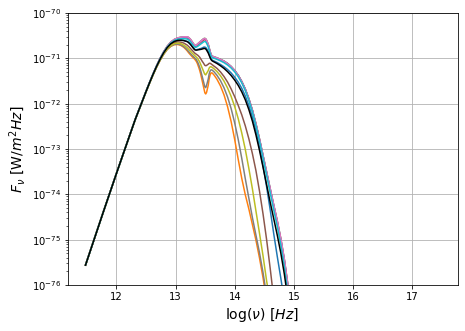

In [23]:
#Test to calculate mean values of a numpy array

SEDs = [np.zeros((132))]*2
fig = plt.figure(figsize=(7, 5))
for i in range(10):
    plt.semilogy(SKIRTORCdict['wavelength'][i], SKIRTORCdict['SED'][i])
    SEDs[1] += SKIRTORCdict['SED'][i]/10
#SEDmean = SEDs/10
plt.semilogy(SKIRTORCdict['wavelength'][0], SEDs[1], color = 'black')
plt.ylim(1e-29, 1e-24)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-76, 1e-70)
print(type(SEDs[1]))

In [24]:
SKIRTORMdict = pickle.load(open('Models/SKIRTOR_mean.pickle', 'rb'), encoding='latin1')  
SKIRTORMdict

,wavelength,SED,incl-values,Dm-values
0,131 11.476687 130 11.536687 129 11.59...,131 4.696267e-76 130 8.074933e-76 129 ...,0.0,2418.060767
1,131 11.476687 130 11.536687 129 11.59...,131 4.699164e-76 130 8.079921e-76 129 ...,10.0,2418.060767
2,131 11.476687 130 11.536687 129 11.59...,131 4.697193e-76 130 8.076537e-76 129 ...,20.0,2418.060767
3,131 11.476687 130 11.536687 129 11.59...,131 4.697300e-76 130 8.076686e-76 129 ...,30.0,2418.060767
4,131 11.476687 130 11.536687 129 11.59...,131 4.683712e-76 130 8.053274e-76 129 ...,40.0,2418.060767
5,131 11.476687 130 11.536687 129 11.59...,131 4.698353e-76 130 8.078358e-76 129 ...,50.0,2418.060767
6,131 11.476687 130 11.536687 129 11.59...,131 4.709018e-76 130 8.096599e-76 129 ...,60.0,2418.060767
7,131 11.476687 130 11.536687 129 11.59...,131 4.700622e-76 130 8.082067e-76 129 ...,70.0,2418.060767
8,131 11.476687 130 11.536687 129 11.59...,131 4.694166e-76 130 8.070867e-76 129 ...,80.0,2418.060767
9,131 11.476687 130 11.536687 129 11.59...,131 4.697808e-76 130 8.077090e-76 129 ...,90.0,2418.060767


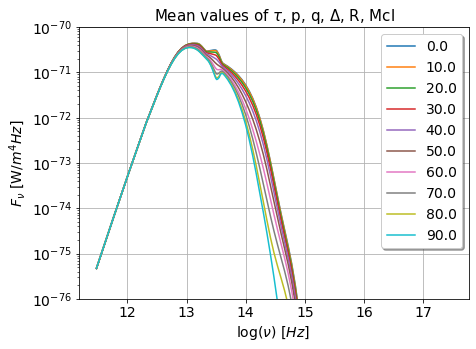

In [28]:
#Plot of the SKIRTOR SEDs obtained using the mean values of the parameters as Sussana and Gabriela did with Nenkova

fig = plt.figure(figsize=(7, 5))
for i in range(10):
    plt.semilogy(SKIRTORMdict['wavelength'][i], SKIRTORMdict['SED'][i], label = str(SKIRTORMdict['incl-values'][i]))
plt.title(r'Mean values of $\tau$, p, q, $\Delta$, R, Mcl', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(fontsize = 14, shadow = True)
plt.grid(True)
plt.ylim(1e-76, 1e-70)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^4 Hz$] ', fontsize = 14) 
plt.show()

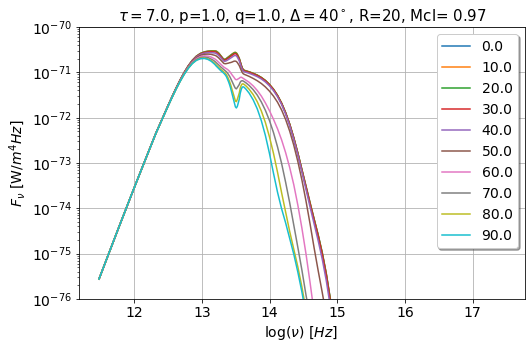

In [29]:
#Plot of the SKIRTOR SEDs obtained using the parameters values of the X-CIGALE paper

fig = plt.figure(figsize=(8, 5))
for i in range(10):
    plt.semilogy(SKIRTORCdict['wavelength'].iloc[i], SKIRTORCdict['SED'].iloc[i], label = str(SKIRTORCdict['incl-values'].iloc[i]))
plt.title(r'$\tau=7.0$, p=1.0, q=1.0, $\Delta=40^\circ$, R=20, Mcl= 0.97', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(fontsize = 14, shadow = True)
plt.ylim(1e-76, 1e-70)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^4 Hz$] ', fontsize = 14) 
plt.show()

In [35]:
SKIRTOR_2p_dict = pickle.load(open('Models/SKIRTOR_mean_2p.pickle', 'rb'), encoding='latin1')  
SKIRTOR_2p_dict

,wavelength,SED,incl-values,Dm-values,oa-values
0,131 11.476687 130 11.536687 129 11.59...,131 1.872787e-76 130 3.212067e-76 129 ...,0.0,754.263117,10.0
1,131 11.476687 130 11.536687 129 11.59...,131 2.707580e-76 130 4.643679e-76 129 ...,0.0,1423.529956,20.0
2,131 11.476687 130 11.536687 129 11.59...,131 3.907485e-76 130 6.707876e-76 129 ...,0.0,1989.550983,30.0
3,131 11.476687 130 11.536687 129 11.59...,131 5.419699e-76 130 9.312639e-76 129 ...,0.0,2457.291629,40.0
4,131 11.476687 130 11.536687 129 11.59...,131 6.563464e-76 130 1.128561e-75 129 ...,0.0,2832.205521,50.0
...,...,...,...,...,...
75,131 11.476687 130 11.536687 129 11.59...,131 5.282969e-76 130 9.076874e-76 129 ...,90.0,2457.291629,40.0
76,131 11.476687 130 11.536687 129 11.59...,131 6.350161e-76 130 1.091825e-75 129 ...,90.0,2832.205521,50.0
77,131 11.476687 130 11.536687 129 11.59...,131 8.015964e-76 130 1.378964e-75 129 ...,90.0,3119.515708,60.0
78,131 11.476687 130 11.536687 129 11.59...,131 9.319860e-76 130 1.603856e-75 129 ...,90.0,3323.081292,70.0


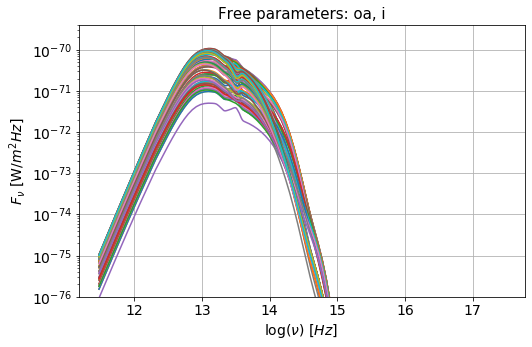

In [50]:
fig = plt.figure(figsize=(8, 5))
for i in range(80):
    plt.semilogy(SKIRTOR_2p_dict['wavelength'].iloc[i], SKIRTOR_2p_dict['SED'].iloc[i])
plt.title(r'Free parameters: oa, i', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
#plt.legend(fontsize = 14, shadow = True)
plt.ylim(1e-76, 4*1e-70)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.show()

In [16]:
SKIRTOR_3p_dict = pickle.load(open('Models/SKIRTOR_mean_3p.pickle', 'rb'), encoding='latin1')  
SKIRTOR_3p_dict

,wavelength,SED,incl-values,Dm-values,oa-values,tv-values
0,131 11.476687 130 11.536687 129 11.59...,131 3.500408e-75 130 6.018344e-75 129 ...,0.0,323.270515,10.0,3.0
1,131 11.476687 130 11.536687 129 11.59...,131 1.825487e-75 130 3.138465e-75 129 ...,0.0,538.591881,10.0,5.0
2,131 11.476687 130 11.536687 129 11.59...,131 3.677215e-75 130 6.321879e-75 129 ...,0.0,754.303104,10.0,7.0
3,131 11.476687 130 11.536687 129 11.59...,131 2.651008e-75 130 4.557099e-75 129 ...,0.0,969.825438,10.0,9.0
4,131 11.476687 130 11.536687 129 11.59...,131 3.639455e-75 130 6.256349e-75 129 ...,0.0,1185.324646,10.0,11.0
...,...,...,...,...,...,...
395,131 11.476687 130 11.536687 129 11.59...,131 3.697415e-75 130 6.358389e-75 129 ...,90.0,1476.449042,80.0,3.0
396,131 11.476687 130 11.536687 129 11.59...,131 2.589436e-75 130 4.454308e-75 129 ...,90.0,2460.565625,80.0,5.0
397,131 11.476687 130 11.536687 129 11.59...,131 3.894155e-75 130 6.697292e-75 129 ...,90.0,3445.104771,80.0,7.0
398,131 11.476687 130 11.536687 129 11.59...,131 2.090532e-75 130 3.596823e-75 129 ...,90.0,4429.391771,80.0,9.0


In [42]:
SKIRTOR_4p_dict = pickle.load(open('Models/SKIRTOR_mean_4p.pickle', 'rb'), encoding='latin1')  
SKIRTOR_4p_dict

,wavelength,SED,incl-values,Dm-values,oa-values,p-values,tv-values
0,131 11.476687 130 11.536687 129 11.59...,131 3.640785e-74 130 6.260211e-74 129 ...,0.0,535.784583,10.0,0.0,3.0
1,131 11.476687 130 11.536687 129 11.59...,131 5.176039e-74 130 8.899319e-74 129 ...,0.0,386.538642,10.0,0.5,3.0
2,131 11.476687 130 11.536687 129 11.59...,131 6.286276e-74 130 1.080824e-73 129 ...,0.0,240.913667,10.0,1.0,3.0
3,131 11.476687 130 11.536687 129 11.59...,131 3.376234e-74 130 5.805546e-74 129 ...,0.0,129.845167,10.0,1.5,3.0
4,131 11.476687 130 11.536687 129 11.59...,131 3.878505e-74 130 6.668861e-74 129 ...,0.0,892.980333,10.0,0.0,5.0
...,...,...,...,...,...,...,...
1595,131 11.476687 130 11.536687 129 11.59...,131 5.863171e-74 130 1.008080e-73 129 ...,90.0,1798.216167,80.0,1.5,9.0
1596,131 11.476687 130 11.536687 129 11.59...,131 3.234812e-74 130 5.562596e-74 129 ...,90.0,8941.906667,80.0,0.0,11.0
1597,131 11.476687 130 11.536687 129 11.59...,131 3.541738e-74 130 6.090347e-74 129 ...,90.0,6467.494167,80.0,0.5,11.0
1598,131 11.476687 130 11.536687 129 11.59...,131 6.134719e-74 130 1.054784e-73 129 ...,90.0,4047.699833,80.0,1.0,11.0


# Test with accretion disc

In [33]:
SN12dict = pickle.load(open('Models/SN12.pickle', 'rb'), encoding='latin1') 
SN12dict

{'description': ['Model created based on Slone and Netzer 2012. Obtained through private communication with H. Netzer.                              UNITS: logBHmass[log Mbh / Musn], EddRatio[log Mdot/Medd], SED[ergs/s/Hz], freq[Hz]'],
 'parameters': ['logBHmass', 'logEddra'],
 'logBHmass-values': array([7.4, 7.7, 8. , 8.3, 8.6, 8.9, 9.2, 9.5, 9.8]),
 'logEddra-values': array([0.00000e+00, 1.00000e-03, 2.00000e-03, 3.00000e-03, 4.00000e-03,
        5.00000e-03, 6.00000e-03, 7.00000e-03, 8.00000e-03, 9.00000e-03,
        1.00000e-02, 1.10000e-02, 1.20000e-02, 1.30000e-02, 1.40000e-02,
        1.50000e-02, 1.60000e-02, 1.70000e-02, 1.80000e-02, 1.90000e-02,
        2.00000e-02, 2.10000e-02, 2.20000e-02, 2.30000e-02, 2.40000e-02,
        2.50000e-02, 2.60000e-02, 2.80000e-02, 2.90000e-02, 3.00000e-02,
        3.10000e-02, 3.40000e-02, 3.60000e-02, 3.80000e-02, 3.90000e-02,
        4.00000e-02, 4.20000e-02, 4.40000e-02, 4.50000e-02, 4.80000e-02,
        5.00000e-02, 5.20000e-02, 5.50000e-02

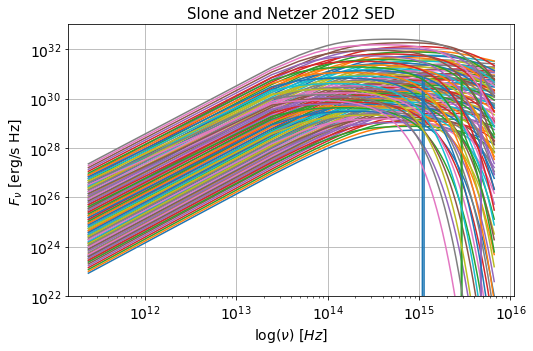

In [124]:
fig = plt.figure(figsize=(8, 5))
for i in range(9):
    for j in range(12):
        plt.loglog(SN12dict['frequency'], SN12dict['SED'][:, i, j])
        
plt.ylim(1e22, 1e33)
plt.title(r'Slone and Netzer 2012 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

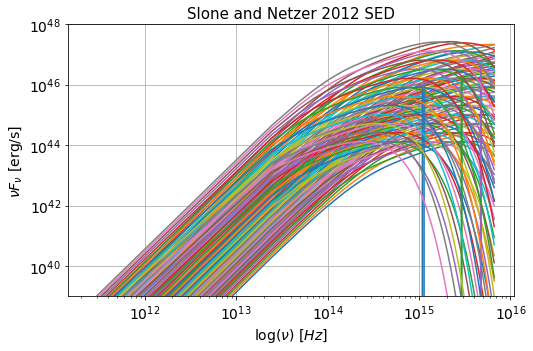

In [125]:
fig = plt.figure(figsize=(8, 5))
for i in range(9):
    for j in range(12):
        plt.loglog(SN12dict['frequency'], SN12dict['SED'][:, i, j]*SN12dict['frequency'])
        
plt.ylim(1e39, 1e48)
plt.title(r'Slone and Netzer 2012 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
#plt.legend(fontsize = 14, shadow = True)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.show()

In [163]:
#Richards models is a unique SED
R06dict = pickle.load(open('Models/R06.pickle', 'rb'), encoding='latin1') 

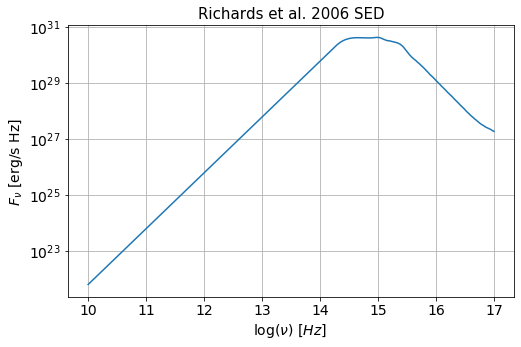

In [60]:
f = 10**R06dict['wavelength']
fig = plt.figure(figsize=(8, 5))

plt.semilogy(R06dict['wavelength'], R06dict['SED'])
        
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

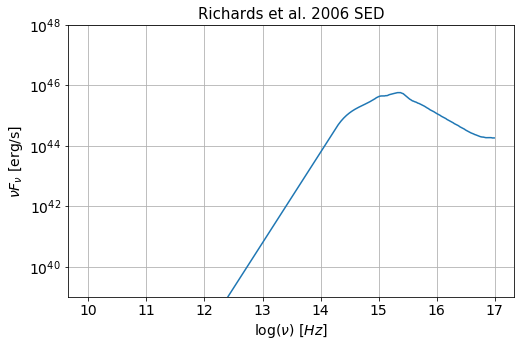

In [61]:
f = 10**R06dict['wavelength']
fig = plt.figure(figsize=(8, 5))

plt.semilogy(R06dict['wavelength'], R06dict['SED']*f)
        
plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.show()

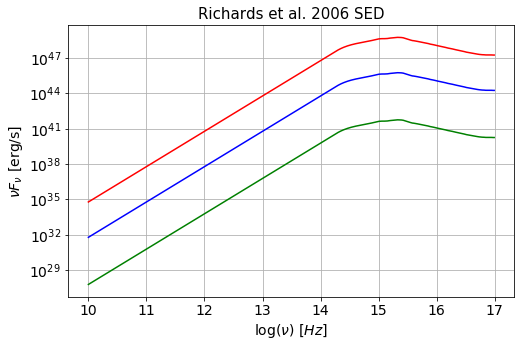

In [62]:
f = 10**R06dict['wavelength']
fig = plt.figure(figsize=(8, 5))

plt.semilogy(R06dict['wavelength'], R06dict['SED']*f*10**(-4), color = 'g')
plt.semilogy(R06dict['wavelength'], R06dict['SED']*f, color = 'b')
plt.semilogy(R06dict['wavelength'], R06dict['SED']*f*10**(3), color = 'r')        
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.show()

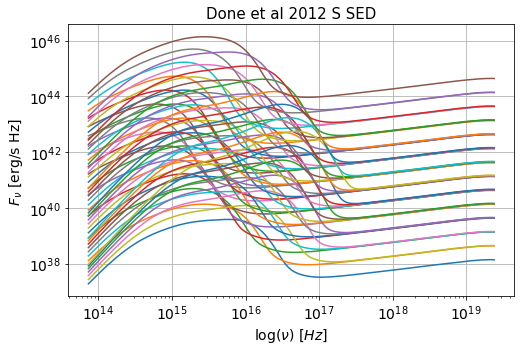

In [14]:
D12_Sdict = pickle.load(open('Models/D12_S.pickle', 'rb'), encoding='latin1') 

fig = plt.figure(figsize=(8, 5))
for i in range(7):
    for j in range(8):
        plt.loglog(D12_Sdict['frequency'], D12_Sdict['SED'][:, i, j]*D12_Sdict['frequency'])
        
#plt.ylim(1e22, 1e33)
plt.title(r'Done et al 2012 S SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

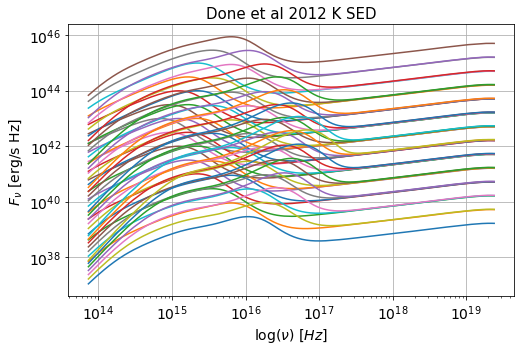

In [15]:
D12_Kdict = pickle.load(open('Models/D12_K.pickle', 'rb'), encoding='latin1') 

fig = plt.figure(figsize=(8, 5))
for i in range(7):
    for j in range(8):
        plt.loglog(D12_Kdict['frequency'], D12_Kdict['SED'][:, i, j]*D12_Kdict['frequency'])
        
#plt.ylim(1e22, 1e33)
plt.title(r'Done et al 2012 K SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

# Minimization routine

In [31]:
def Best_BB(SN12_f, SN12_SED, BH_mass, EddR, BB):
    
    distances = np.zeros((len(BB)))
    #BB = np.linspace(-4, 3, 700)
    for i in range(len(BB)):
        R06 = np.zeros((438, 2))
        R06[:, 0] = 10**R06dict['wavelength']
        R06[:, 1] = R06dict['SED']*R06[:, 0]*10**BB[i]

        SN12 = np.zeros((276, 2))
        SN12[:, 0] = SN12_f
        SN12[:, 1] = SN12_SED*SN12_f

        distances[i] = np.sum(distance.cdist(R06, SN12, 'euclidean'))
        #print(distance.cdist(R06, SN12, 'euclidean').shape)
    
    dis_min = distances.min()  ## np.argmin()
    pos_min = np.where(distances == dis_min)[0][0]
    
    fig = plt.figure(figsize=(8, 5))
    plt.loglog(R06[:, 0], R06dict['SED']*R06[:, 0]*10**BB[pos_min], label = 'BB = ' + str(BB[pos_min])) 
    plt.loglog(SN12_f, SN12_SED*SN12_f, label = 'BH_mass = {}, EddR = {}'.format(BH_mass, EddR))
    plt.legend(fontsize = 10, shadow = True)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.grid(True)
    plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
    plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
    plt.close()
    return BB[pos_min], fig


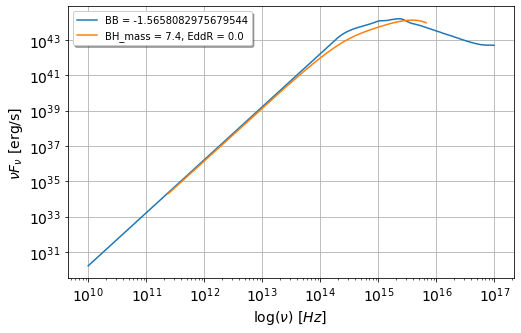

In [32]:
Best_BB(SN12dict['frequency'], SN12dict['SED'][:, 0, 0], SN12dict['logBHmass-values'][0], SN12dict['logEddra-values'][0],  np.linspace(-4.5, 2.5, 700))[1]

In [11]:
parameters = np.zeros((108,3))
bb_matrix = np.zeros((9,12))
k = 0
for i in range(9):
    for j in range(12):
        MBH = SN12dict['logBHmass-values'][i]
        EddR = SN12dict['logEddra-values'][j]
        BB = Best_BB(SN12dict['frequency'], SN12dict['SED'][:, i, j], MBH, EddR, np.linspace(-12.0, 2.0, 1000))[0]
        parameters[k]= [BB, MBH, EddR]
        bb_matrix[i,j] = BB
        k += 1
        if k == 27:
            print('25 % of the finished process...')
        elif k == 54:
            print('50 % of the finished process...')
        elif k == 81:
            print('75 % of the finished process...')
        elif k == 108:
            print('100 % of the finished process...')

25 % of the finished process...
50 % of the finished process...
75 % of the finished process...
100 % of the finished process...


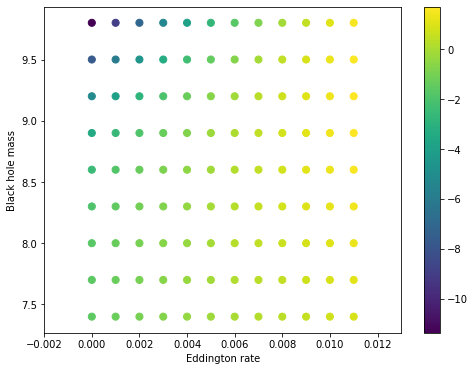

In [12]:
bb = parameters[:,0]
Mbh = parameters[:,1]
Edd_r = parameters[:,2]
#plt.hist(bb, bins= 30)

f, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(Edd_r, Mbh, c= bb, s= 50)
cb = f.colorbar(sc, ax=ax)
ax.set_ylabel('Black hole mass')
ax.set_xlabel('Eddington rate')
#ax.set_xlim((-4, -0.5))
ax.set_xlim((-0.002, 0.013));

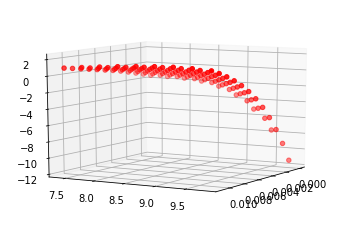

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Edd_r, Mbh, bb, c= 'r', marker= 'o')
ax.view_init(10, 30)
plt.show()

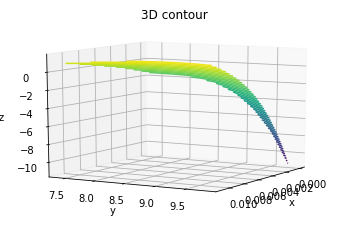

In [15]:
from mpl_toolkits import mplot3d
X, Y = np.meshgrid(SN12dict['logEddra-values'][0:12], SN12dict['logBHmass-values'])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X,Y, bb_matrix, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D contour')
ax.view_init(10, 30)
plt.show()

Text(-0.03685266790122222, -0.08366966968990466, 'BB')

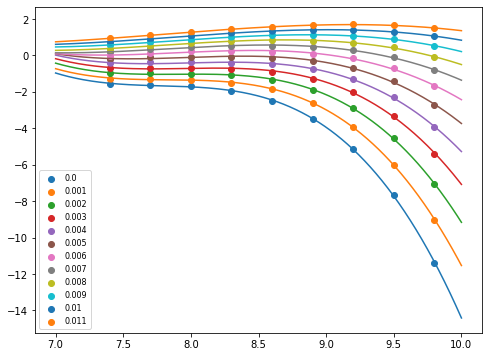

In [16]:
def bb_func(mbh, a, b, c, d):
    return a*mbh**3 + b*mbh**2 +c*mbh + d


edd_par = np.zeros((12, 5))
fig = plt.figure(figsize=(8, 6))
for i in range(12):
    plt.scatter(parameters[i::12][:,1], parameters[i::12][:,0], label = str(parameters[i][2]))
    p, pcov = optimize.curve_fit(bb_func, parameters[i::12][:,1], parameters[i::12][:,0])
    x = np.linspace(7,10, 500)
    plt.plot(x, bb_func(x, p[0], p[1], p[2], p[3]))
    edd_par[i]= [parameters[i][2], p[0], p[1], p[2], p[3]]
plt.legend(fontsize = 8)
ax.set_xlabel('Black hole mass')
ax.set_ylabel('BB')

[ 7.13208873e-03 -2.33120630e-01  1.26263980e+02  3.44714787e+01]
[ 7.21371877e-03  5.40967804e+00 -2.94889247e+03 -8.09975018e+02]
[ 7.29756532e-03 -4.13642480e+01  2.30403566e+04  6.37559241e+03]
[ 7.38454582e-03  1.04548247e+02 -5.99327479e+04 -1.66089217e+04]


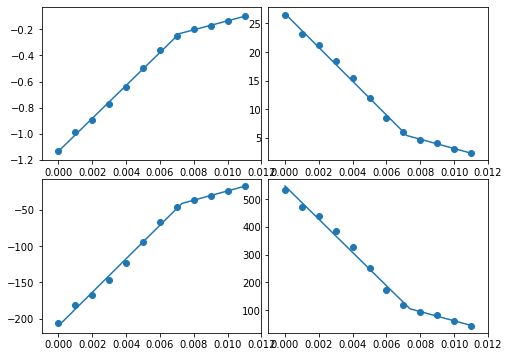

In [17]:
plt.figure(figsize = (8,6))
fig = gridspec.GridSpec(2, 2)
fig.update(wspace=0.03, hspace=0.12)
plt.subplot(fig[0])
plt.scatter(edd_par[:,0], edd_par[:,1])

def a_func(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*(x-x0) + y0, lambda x:k2*(x-x0) + y0])

pa, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,1], [0.007, -0.1, 150, 30])
print(pa)
x = np.linspace(edd_par[:,0].min(), edd_par[:,0].max(), 500)
plt.plot(x, a_func(x, *pa))
plt.xlim(-0.001, 0.012)

plt.subplot(fig[1])
plt.scatter(edd_par[:,0], edd_par[:,2])
pb, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,2], [0.007, 5, -2500, -800])
print(pb)
plt.plot(x, a_func(x, *pb))
plt.xlim(-0.001, 0.012)

plt.subplot(fig[2])
plt.scatter(edd_par[:,0], edd_par[:,3])
pc, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,3], [0.007,  -40, 2500, 6000])
print(pc)
plt.plot(x, a_func(x, *pc))
plt.xlim(-0.001, 0.012)

plt.subplot(fig[3])
plt.scatter(edd_par[:,0], edd_par[:,4])
pd, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,4], [0.007,  100, -50000, -16000])
print(pd)
plt.plot(x, a_func(x, *pd))
plt.xlim(-0.001, 0.012)
plt.show()

factor_b = np.array([pb[i]/pa[i] for i in range(1,4)]).mean()
factor_c = np.array([pc[i]/pa[i] for i in range(1,4)]).mean()
factor_d = np.array([pd[i]/pa[i] for i in range(1,4)]).mean()

In [18]:
def bb_surf_mean(eddr, mbh):
    a = a_func(eddr, *pa)
    b = a_func(eddr, pa[0], pa[1]*factor_b, pa[2]*factor_b, pa[3]*factor_b)
    c = a_func(eddr, pa[0], pa[1]*factor_c, pa[2]*factor_c, pa[3]*factor_c)
    d = a_func(eddr, pa[0], pa[1]*factor_d, pa[2]*factor_d, pa[3]*factor_d)
    
    return a*mbh**3 + b*mbh**2 +c*mbh + d

In [19]:
def bb_surf(eddr, mbh):
    """
    Function to calculate BB from the black hole mass and Eddington accretion rate. BB is calculated from a 
    grade 3 polynomial that depends on black hole mass and which parameters are piecewise functions of the
    Eddington accretion rate. The parameters in piecewise functions used here were fitted to data previously
    to save time in computing. The data used to fit the functions comes from a minization routine that calculates
    the best BB in a range between -12 and 2 that makes R06 model as close as possible to each SN12 models for a
    given logEddra and logBHmass.
    
    Parameters:
    -----------
    eddr : logEddra in units of [log Mdot/Medd]
    mbh : logBHmass in units of [log Mbh / Musn]
    
    Return:
    ----------
    BB : Value of the accretion disk normalization
    """      
    def par_func(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*(x-x0) + y0, lambda x:k2*(x-x0) + y0])

    pa = np.array([7.13208873e-03, -2.33120630e-01,  1.26263980e+02,  3.44714787e+01])
    pb = np.array([ 7.21371877e-03,  5.40967804e+00, -2.94889247e+03, -8.09975018e+02])
    pc = np.array([ 7.29756532e-03, -4.13642480e+01,  2.30403566e+04,  6.37559241e+03])
    pd = np.array([ 7.38454582e-03,  1.04548247e+02, -5.99327479e+04, -1.66089217e+04])
    
    a = par_func(eddr, *pa)
    b = par_func(eddr, *pb)
    c = par_func(eddr, *pc)
    d = par_func(eddr, *pd)
    
    BB = a*mbh**3 + b*mbh**2 +c*mbh + d
    return BB

In [33]:
%matplotlib inline 
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Edd_r, Mbh, bb, c= 'r', marker= 'o')
X, Y = np.meshgrid(SN12dict['logEddra-values'][0:12], SN12dict['logBHmass-values'])
Z = bb_surf(X,Y)
ax.plot_surface(X, Y, Z, linewidth=0)
ax.view_init(10, 45)
plt.show()

# Schreiber with and without radio

In [13]:
def RADIO(LIR, conv_factor, sb_nu0, sb_Fnu0, RAD_excess):
    
    #np.random.normal(2.64, 0.26,1)
    q_IR_r14 = 2.64 #+ rad_excess
    alpha_syn  = -0.75
    alpha_th = -0.1
    nth_frac =0.9

    L14 = 10**(np.log10(LIR*conv_factor)-q_IR_r14)/3.75e12 #1.4e9 #to Wats
    nu_spacing= (np.log10(sb_nu0)[2]-np.log10(sb_nu0)[1])
    radio_points = (np.log10(sb_nu0)[0]-9)/nu_spacing
    radio_nu14= np.log10(1.4e9)

    radio_nu = np.arange(np.log10(sb_nu0)[0]- nu_spacing*int(radio_points),np.log10(sb_nu0)[0], nu_spacing)
    radio_SB_nu = np.concatenate((radio_nu, np.log10(sb_nu0)[:np.argmax(sb_Fnu0)]))
    optical_nu = np.arange(np.log10(sb_nu0)[-1], 16, nu_spacing)
    radio_opt_nu = np.concatenate((radio_nu, np.log10(sb_nu0), optical_nu))
    #all_nu=  np.concatenate((radio_nu, np.log10(sb_nu0)))

    Lsb = np.concatenate((sb_Fnu0[0]*1e-4*np.ones(len(radio_nu)),sb_Fnu0, sb_Fnu0[-1]*1e-4*np.ones(len(optical_nu))))

    Lsyn_0 = 10**(-1*alpha_syn* np.log10(1.4e9/10**radio_SB_nu[0])) * L14*(nth_frac)
    Lsyn_SB = Lsyn_0 * 10**(alpha_syn* np.log10(10**radio_SB_nu/10**radio_SB_nu[0])) 
    #Lsyn = np.concatenate((Lsyn_rad, Lsyn_rad[-1]*1e-4*np.ones(len(all_nu)-len(Lsyn_rad))))
    Lsyn = np.concatenate((Lsyn_SB, 0*np.ones(len(radio_opt_nu)-len(Lsyn_SB))))

    Lth_0 = 10**(-1*alpha_th* np.log10(1.4e9/10**radio_SB_nu[0])) * L14*(1.-nth_frac)
    Lth_SB= Lth_0* 10**(alpha_th* np.log10(10**radio_SB_nu/10**radio_SB_nu[0])) 
    #Lth = np.concatenate((Lth_rad, Lth_rad[-1]*1e-4*np.ones(len(all_nu)-len(Lth_rad))))
    Lth = np.concatenate((Lth_SB, 0*np.ones(len(radio_opt_nu)-len(Lth_SB))))
    
    Lsyn_AGN = RAD_excess*L14*10**(alpha_syn* np.log10(10**radio_opt_nu/10**radio_opt_nu[0])) 

    Lir_rad= Lsb+Lsyn+Lth+Lsyn_AGN

    return  radio_opt_nu, Lir_rad, Lsyn, Lth, Lsb, Lsyn_AGN

In [3]:
dusttable = Table.read('Models/s17_lowvsg_dust.fits')
pahstable = Table.read('Models/s17_lowvsg_pah.fits')
dusttable

"LAM [150,721]","SED [150,721]",UMIN [150],UMEAN [150],LIR [150],LFIR [150],LBOL [150],L8 [150],TDUST [150],TDUST_PEAK [150],TDUST_LW [150],MASS_FRAC
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.09877818422634621 .. 30000.000000000007,2.884989700633898e-21 .. 2.022607313608977e-06,0.09999999999999998 .. 300.0,0.26451371122875333 .. 790.6332857549645,47.19987698458022 .. 140477.49664224335,12.490381652138764 .. 60242.971781359236,47.5517640169814 .. 141577.51531377863,0.3570634660939377 .. 2685.8364398607937,14.241288337446223 .. 60.21153795212259,15.266432244713348 .. 66.19604567557667,17.987179747228364 .. 74.05456213680702,0.97715


In [5]:
Dwl, DnuLnu = dusttable['LAM'],dusttable['SED'] #micron, Lsun
Pwl, PnuLnu = pahstable['LAM'],pahstable['SED'] #micron, Lsun
Tdust = np.array(dusttable['TDUST'])[0] #K
LIR=  np.array(dusttable['LIR'])[0]*3.826e33
fracPAH = np.concatenate(((np.arange(0.0, 0.1, 0.01)/100.),(np.arange(0.1, 5.5, 0.1)/100.)))
RADexc= np.logspace(-1, 2, 10) #np.logspace(-1, 3, 10)
#RADexc= np.arange(-1.5, 2, 0.35) #np.arange(-0.5, 5, 0.6) np.arange(-0.5, 0.26, 0.076)
#RADexc= np.arange(5, 105, 5)

idxs=[np.arange(len(Tdust)), np.arange(len(fracPAH)),np.arange(len(RADexc))]
par_idxs_combinations = np.array(list(itertools.product(*idxs)))
conv_factor= 3.826e-33 #1e-6
Dnu= (Dwl[0] * u.micron).to(u.Hz, equivalencies=u.spectral())
Pnu= (Pwl[0] * u.micron).to(u.Hz, equivalencies=u.spectral())
DLnu= np.array(DnuLnu[0])/Dnu #*conv_factor #* u.Lsun.to(u.W)
PLnu=np.array(PnuLnu[0])/Pnu #*conv_factor#* u.Lsun.to(u.W)

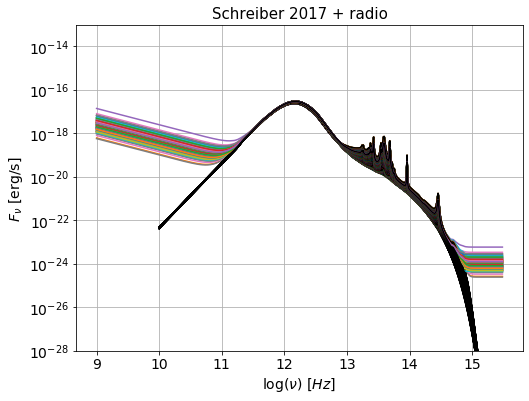

In [33]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[2205:4505][::20]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0= RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0)
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0, color = 'black')

plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s] ', fontsize = 14) 
plt.ylim(1e-28, 1e-13)
plt.grid(True)

### Plot with 5 differents temperatures and fracPAH

In [16]:
idxs_plot1 = np.zeros((500, 3))
for i in range(5):
    for j in range(5):
        idxs_plot1[100*i + 20*j:100*i + 20*j +20] = par_idxs_combinations[38400*i + 300*j: 38400*i + 300*j +20]
idxs_plot1 = idxs_plot1.astype(int)

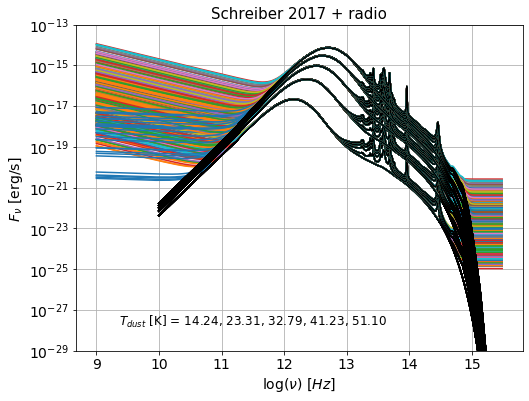

In [17]:
fig = plt.figure(figsize=(8, 6))
for c in idxs_plot1:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0= RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0)
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0, color = 'black')

plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s] ', fontsize = 14) 
plt.annotate(r'$T_{dust}$ [K] = 14.24, 23.31, 32.79, 41.23, 51.10 ', xy=(9.2, 6*1e-29), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 0)
plt.ylim(1e-29, 1e-13)
plt.grid(True)

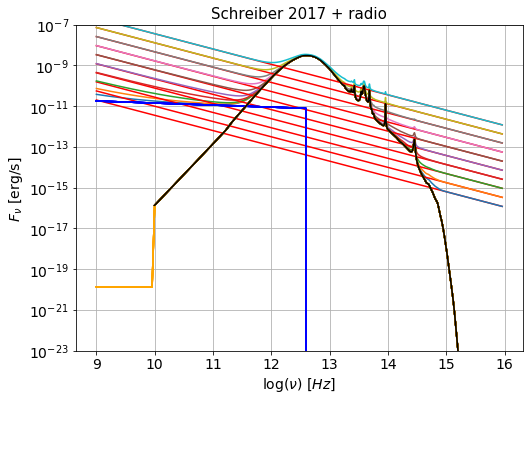

In [28]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[57900: 57910]: #[115800: 115820]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0, Lsyn, Lth, Lsb = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])#RADexc[re]
    plt.semilogy(rad_sb_nu0, Lsyn, color = 'red')
    plt.semilogy(rad_sb_nu0, Lth, color = 'blue')
    plt.semilogy(rad_sb_nu0, Lsb, color = 'orange')
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0)
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0, color = 'black')

plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.annotate(r'$T_{dust}$ [K] = 41.23, $frac_{PAH}$ = 0.021', xy=(9.2, 4*1e-29), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 0)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s] ', fontsize = 14) 
#plt.ylim(1e-29, 1e-13)
plt.ylim(1e-23, 1e-7)
plt.grid(True)

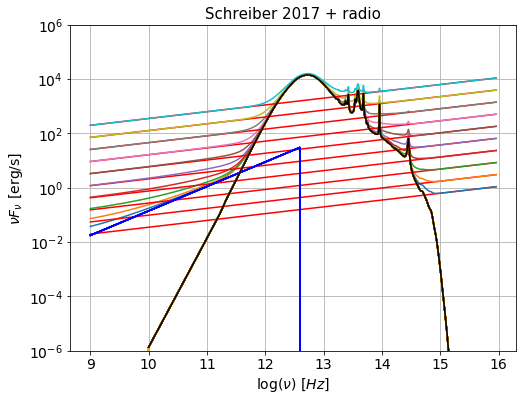

In [31]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[57900: 57910]: #[115800: 115820]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0, Lsyn, Lth, Lsb = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    plt.semilogy(rad_sb_nu0, Lsyn*10**rad_sb_nu0, color = 'red')
    plt.semilogy(rad_sb_nu0, Lth*10**rad_sb_nu0, color = 'blue')
    plt.semilogy(rad_sb_nu0, Lsb*10**rad_sb_nu0, color = 'orange')
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0*10**rad_sb_nu0)
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0*10**np.log10(sb_nu0), color = 'black')


plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
#plt.annotate(r'$T_{dust}$ [K] = 41.23, $frac_{PAH}$ = 0.021', xy=(9.2, 4*1e-29), 
    #         xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 0)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.ylim(1e-6, 1e6)
plt.grid(True)

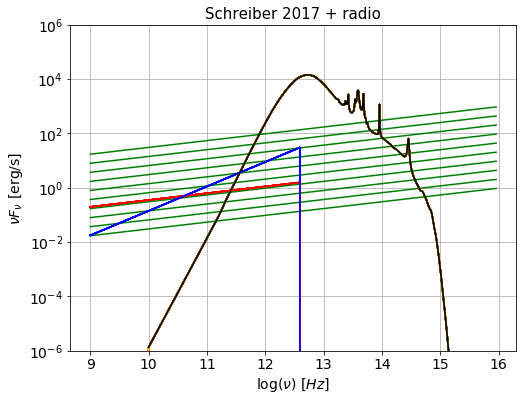

In [14]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[57900: 57910]: #[115800: 115820]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0, Lsyn, Lth, Lsb, Lsyn_AGN = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    plt.semilogy(rad_sb_nu0, Lsyn*10**rad_sb_nu0, color = 'red')
    plt.semilogy(rad_sb_nu0, Lth*10**rad_sb_nu0, color = 'blue')
    plt.semilogy(rad_sb_nu0, Lsb*10**rad_sb_nu0, color = 'orange')
    plt.semilogy(rad_sb_nu0, Lsyn_AGN*10**rad_sb_nu0, color = 'green')
    #plt.semilogy(rad_sb_nu0, rad_sb_Fnu0*10**rad_sb_nu0)
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0*10**np.log10(sb_nu0), color = 'black')


plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
#plt.annotate(r'$T_{dust}$ [K] = 41.23, $frac_{PAH}$ = 0.021', xy=(9.2, 4*1e-29), 
    #         xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 0)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.ylim(1e-6, 1e6)
plt.grid(True)

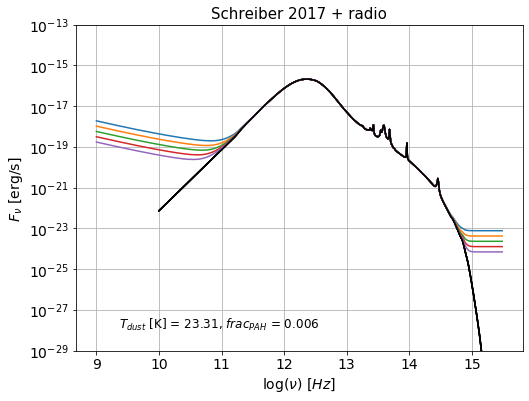

In [7]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[9675: 9680]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0= RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    #Lsyn, Lth = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])[2:4]
    #rad_nu2, Lsyn = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])[2:4]
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0)
    #plt.semilogy(rad_sb_nu0, Lsyn, color = 'blue')
    #plt.semilogy(rad_nu2, Lsyn, color = 'blue')
    #plt.semilogy(rad_sb_nu0, Lth, color = 'red')
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0, color = 'black')

plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.annotate(r'$T_{dust}$ [K] = 23.31, $frac_{PAH}$ = 0.006', xy=(9.2, 4*1e-29), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 0)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s] ', fontsize = 14) 
plt.ylim(1e-29, 1e-13)
plt.grid(True)

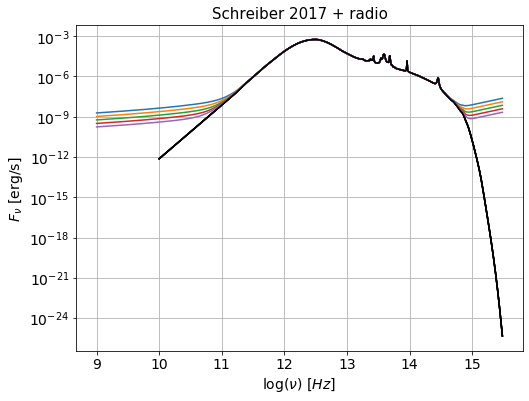

In [10]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[9675: 9680]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0= RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    #Lsyn, Lth = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])[2:4]
    #rad_nu2, Lsyn = RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])[2:4]
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0*10**rad_sb_nu0)
    #plt.semilogy(rad_sb_nu0, Lsyn, color = 'blue')
    #plt.semilogy(rad_nu2, Lsyn, color = 'blue')
    #plt.semilogy(rad_sb_nu0, Lth, color = 'red')
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0*10**np.log10(sb_nu0), color = 'black')

plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.annotate(r'$T_{dust}$ [K] = 23.31, $frac_{PAH}$ = 0.006', xy=(9.2, 4*1e-29), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 0)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s] ', fontsize = 14) 
#plt.ylim(1e-29, 1e-13)
plt.grid(True)

# Dictionary for S17 model with radio estimation

In [2]:
S17_RADdict = pickle.load(open('Models/S17_radio1.pickle', 'rb'), encoding='latin1') 
S17_RADdict

,frequency,SED,fracPAH-values,Tdust-values,RADexc-values,LIR
0,"[9.00075473076182, 9.04418710978123, 9.0876194...","[9.24735884495099e-14, 8.85108865471942e-14, 8...",0.000,14.241288,0.100000,1.805867e+35
1,"[9.00075473076182, 9.04418710978123, 9.0876194...","[1.7951301674556935e-13, 1.6926074049730576e-1...",0.000,14.241288,0.278256,1.805867e+35
2,"[9.00075473076182, 9.04418710978123, 9.0876194...","[4.2170539631350243e-13, 3.9395200583304084e-1...",0.000,14.241288,0.774264,1.805867e+35
3,"[9.00075473076182, 9.04418710978123, 9.0876194...","[1.0956200792231712e-12, 1.019168798786806e-12...",0.000,14.241288,2.154435,1.805867e+35
4,"[9.00075473076182, 9.04418710978123, 9.0876194...","[2.9708277164389033e-12, 2.758871664438091e-12...",0.000,14.241288,5.994843,1.805867e+35
...,...,...,...,...,...,...
95995,"[9.00075473076182, 9.04418710978123, 9.0876194...","[2.43714340353263e-08, 2.261841873789059e-08, ...",0.054,60.211538,16.681005,5.374669e+38
95996,"[9.00075473076182, 9.04418710978123, 9.0876194...","[6.758341186488117e-08, 6.270784679299179e-08,...",0.054,60.211538,46.415888,5.374669e+38
95997,"[9.00075473076182, 9.04418710978123, 9.0876194...","[1.8782330706247477e-07, 1.742590617568196e-07...",0.054,60.211538,129.154967,5.374669e+38
95998,"[9.00075473076182, 9.04418710978123, 9.0876194...","[5.223979579649386e-07, 4.846569437820472e-07,...",0.054,60.211538,359.381366,5.374669e+38


In [29]:
filtro = S17_RADdict[(S17_RADdict['Tdust-values'] == 14.241288337446223) & (S17_RADdict['fracPAH-values'] == 0.0) & (S17_RADdict['RADexc-values'] == 0.1) ]
#type(filtro['frequency'].values.item())
#type(filtro['SED'].values.item())
type(filtro['LIR'].values.item())

float

In [18]:
import zipfile

z = zipfile.ZipFile('Models/S17_radio.zip')
z.extractall('Models/')
z.close()

In [19]:
S17_RADdict = pickle.load(open('Models/S17_radio.pickle', 'rb'), encoding='latin1') 
#S17_RADdict

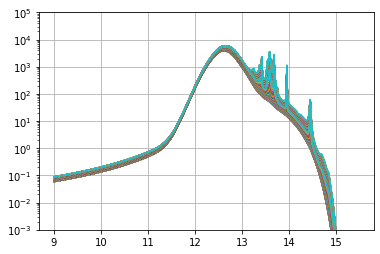

In [6]:
for i in range(4000,4500):
    f = S17_RADdict.iloc[i, 0]
    SED = S17_RADdict.iloc[i, 1]
    plt.semilogy(f, SED*10**f)
plt.ylim(plt.ylim(1e-3, 1e5))
plt.grid()
plt.show()

## BB with and without X-Rays

In [21]:
def XRAYS(bbb_nu, bbb_Fnu):
    f = interp1d(bbb_nu, bbb_Fnu, kind = 'nearest', bounds_error=False, fill_value=0.) 
    nu_2500 = (3*1e8)/(2500*1e-10)            #frequency at 2500 Angstroms
    L_2500 = f(np.log10(nu_2500))             # Luminosity at 2500 Angstroms

    mean_alpha = -0.137*np.log10(L_2500) + 2.638   #alpha_OX-L_2500 relation
    sigma_alpha = 0.1
    alpha = np.random.normal(mean_alpha, sigma_alpha, 1)
    nu_2kev = 4.83598*1e17                    #frequency at 2 keV
    #xray_nu = np.logspace(np.log10(nu_2500), np.log10(nu_2kev), 500)
    xray_nu = np.logspace(17, 18.5, 500)
    xray_Fnu = L_2500*10**(alpha*(np.log10(xray_nu/nu_2500)))
    #xray_Fnu = L_2500*10**alpha*(xray_nu/nu_2500)**(1-1.7)
    bbb_nu_x = np.concatenate((bbb_nu, np.log10(xray_nu)))
    bbb_Fnu_x = np.concatenate((bbb_Fnu, xray_Fnu))
    #bbb_nu_x = np.concatenate((bbb_nu[bbb_nu < np.log10((3*1e8)/(2500*1e-10))], np.log10(xray_nu)))
    #bbb_Fnu_x = np.concatenate((bbb_Fnu[bbb_nu < np.log10((3*1e8)/(2500*1e-10))], xray_Fnu))
    
    return bbb_nu_x, bbb_Fnu_x

In [2]:
def XRAYS2(bbb_nu, bbb_Fnu, sigma):
    f = interp1d(bbb_nu, bbb_Fnu, kind = 'nearest', bounds_error=False, fill_value=0.) 
    nu_2500 = (3*1e8)/(2500*1e-10)            #frequency at 2500 Angstroms
    L_2500 = f(np.log10(nu_2500))             # Luminosity at 2500 Angstroms

    mean_alpha = -0.137*np.log10(L_2500) + 2.638   #alpha_OX-L_2500 relation
    #sigma_alpha = 0.1
    #alpha = np.random.normal(mean_alpha, sigma_alpha, 1)
    alpha = mean_alpha + sigma
    nu_2kev = 4.83598*1e17                    #frequency at 2 keV
    Fnu_2kev = L_2500*10**(alpha*(np.log10(nu_2kev/nu_2500)))
    
    #Proportionality constant
    h = 4.135667731*1e-15*1e-3   #eV/Hz --> keV/Hz
    Gamma = 1.8
    a = Fnu_2kev/((h*nu_2kev)**(-Gamma+1)*np.e**(-nu_2kev/(7.2540*1e19)))
    
    xray_nu = np.logspace(17, 19, 1000)
    xray_Fnu = a*(h*xray_nu)**(-Gamma+1)*np.e**(-xray_nu/(7.2540*1e19))
    
    return np.log10(xray_nu), xray_Fnu

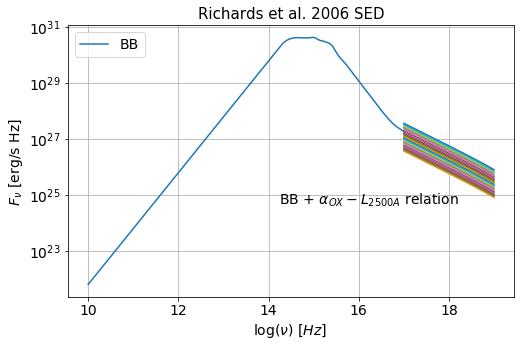

In [4]:
R06dict = pickle.load(open('Models/R06.pickle', 'rb'), encoding='latin1') 
fig = plt.figure(figsize=(8, 5))
plt.semilogy(R06dict['wavelength'], R06dict['SED'], label = 'BB')

sigmas = np.arange(-0.2, 0.2, 0.02)
for i in sigmas:
    bbb_nu = R06dict['wavelength']
    bbb_Fnu = R06dict['SED']
    xray_nu_x, xray_Fnu_x = XRAYS2(bbb_nu[bbb_nu < 16.5], bbb_Fnu[bbb_nu < 16.5], i)
    plt.semilogy(xray_nu_x, xray_Fnu_x)
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.annotate(r'BB + $\alpha_{OX}-L_{2500 A}$ relation', xy=(14, 2*1e24), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=14,  rotation = 0)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.legend(fontsize = 14, loc = 2)
plt.show()

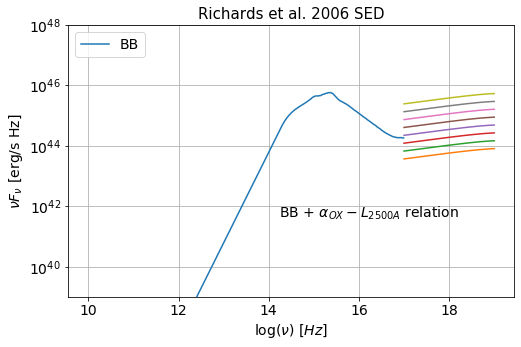

In [16]:
fig = plt.figure(figsize=(8, 5))
bbb_nu = R06dict['wavelength']
bbb_Fnu = R06dict['SED']
plt.semilogy(bbb_nu[bbb_nu < 17], bbb_Fnu[bbb_nu < 17]*10**bbb_nu[bbb_nu < 17], label = 'BB')

sigmas = np.arange(-0.2, 0.55, 0.1)
for i in sigmas:
    xray_nu, xray_Fnu = XRAYS2(bbb_nu, bbb_Fnu, i)
    plt.semilogy(xray_nu, xray_Fnu*10**xray_nu)
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.annotate(r'BB + $\alpha_{OX}-L_{2500 A}$ relation', xy=(14, 2*1e41), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=14,  rotation = 0)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.ylim(1e39, 1e48)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.legend(fontsize = 14, loc = 2)
plt.show()

In [15]:
R06dict = pickle.load(open('Models/R06.pickle', 'rb'), encoding='latin1')
bbb_nu = R06dict['wavelength']
bbb_Fnu = R06dict['SED']

xray_nu_x, xray_Fnu_x = XRAYS2(bbb_nu[bbb_nu < 16.5], bbb_Fnu[bbb_nu < 16.5], 0)

f = interp1d(xray_nu_x, xray_Fnu_x, kind = 'nearest', bounds_error=False, fill_value=0.) 

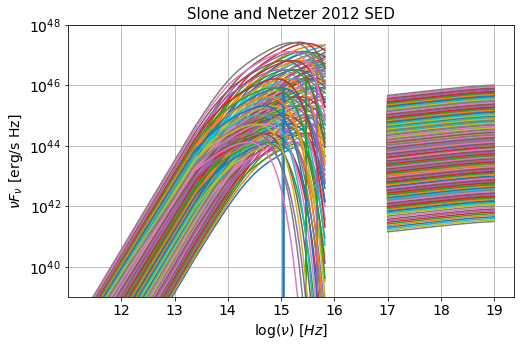

In [16]:
SN12dict = pickle.load(open('Models/SN12.pickle', 'rb'), encoding='latin1') 
fig = plt.figure(figsize=(8, 5))

sigmas = np.arange(-0.2, 0.2, 0.02)
for i in range(9): #9
    for j in range(12): #12
        bbb_nu = np.log10(SN12dict['frequency'])
        bbb_Fnu = SN12dict['SED'][:, i, j]
        plt.semilogy(bbb_nu, bbb_Fnu*10**bbb_nu)
        
        for k in sigmas:
            bbb_nu_x, bbb_Fnu_x = XRAYS2(bbb_nu, bbb_Fnu, k)      
            plt.semilogy(bbb_nu_x, bbb_Fnu_x*10**bbb_nu_x)
        
#plt.ylim(1e22, 1e33)
plt.ylim(1e39, 1e48)
plt.title(r'Slone and Netzer 2012 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

# Importance of different ranges of interpolation

(1e+41, 1e+46)

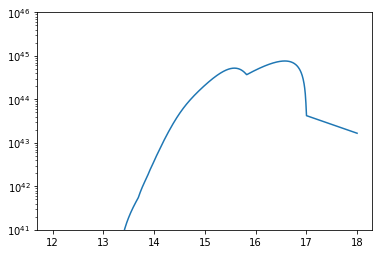

In [51]:
SN12dict = pickle.load(open('Models/SN12.pickle', 'rb'), encoding='latin1') 
bbb_nu = np.log10(SN12dict['frequency'])
bbb_Fnu = SN12dict['SED'][:, 1, 2]
bbb_nu_x, bbb_Fnu_x = XRAYS(bbb_nu, bbb_Fnu)   

f = interp1d(bbb_nu_x, bbb_Fnu_x,  bounds_error=False, fill_value=0.) 
plt.semilogy(np.linspace(12, 18, 1000), f(np.linspace(12, 18, 1000))*10**np.linspace(12, 18, 1000))
plt.ylim(1e41, 1e46)

(1e+41, 1e+46)

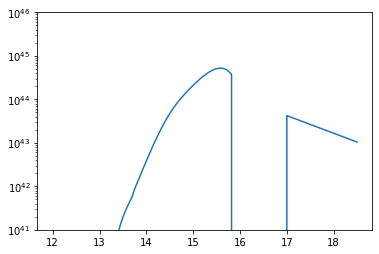

In [52]:
f1 = interp1d(bbb_nu_x[bbb_nu_x < 17], bbb_Fnu_x[bbb_nu_x < 17],  bounds_error=False, fill_value=0.) 
y1 = f1(np.linspace(12,17, 1000))*10**np.linspace(12,17, 1000)

f2 = interp1d(bbb_nu_x[bbb_nu_x >= 17], bbb_Fnu_x[bbb_nu_x >= 17],  bounds_error=False, fill_value=0.) 
y2 = f2(np.linspace(17,18.5, 1000))*10**np.linspace(17,18.5, 1000)
plt.semilogy(np.concatenate((np.linspace(12,17, 1000), np.linspace(17,18.5, 1000))) , np.concatenate((y1,y2)))
plt.ylim(1e41, 1e46)

# Filter Fnu

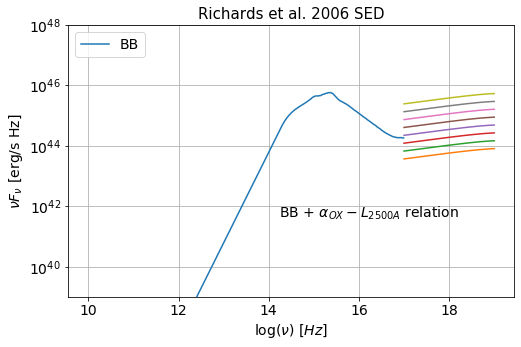

In [4]:
R06dict = pickle.load(open('Models/R06.pickle', 'rb'), encoding='latin1')

fig = plt.figure(figsize=(8, 5))
bbb_nu = R06dict['wavelength']
bbb_Fnu = R06dict['SED']
plt.semilogy(bbb_nu[bbb_nu < 17], bbb_Fnu[bbb_nu < 17]*10**bbb_nu[bbb_nu < 17], label = 'BB')

sigmas = np.arange(-0.2, 0.55, 0.1)
for i in sigmas:
    xray_nu, xray_Fnu = XRAYS2(bbb_nu, bbb_Fnu, i)
    plt.semilogy(xray_nu, xray_Fnu*10**xray_nu)
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.annotate(r'BB + $\alpha_{OX}-L_{2500 A}$ relation', xy=(14, 2*1e41), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=14,  rotation = 0)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.ylim(1e39, 1e48)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.legend(fontsize = 14, loc = 2)
plt.show()

In [5]:
RX_filter = np.loadtxt(open('Filters/XR_14-195keV.txt', 'rb'), encoding='latin1')
Galex_filter = np.loadtxt(open('Filters/galex2500.res', 'rb'), encoding='latin1')

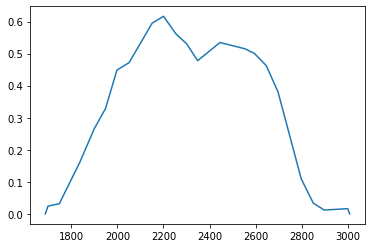

In [81]:
RXfilter = RX_filter[:,0], RX_filter[:,1]
Galexfilter = 15.1143, Galex_filter[:,0], Galex_filter[:,1]
plt.plot(Galex_filter[:,0], Galex_filter[:,1])

In [49]:
c = 2.997e8
Angstrom = 1e10

def fluxlambda_2_fluxnu (flux_lambda, wl_angst):
    """
    Calculate F_nu from F_lambda.
    """
    flux_nu = flux_lambda * (wl_angst**2. ) / c /Angstrom
    return flux_nu
def fluxnu_2_fluxlambda (flux_nu, wl_angst):
    """
    Calculate F_lambda from  F_nu.
    """
    flux_lambda = flux_nu / wl_angst**2 *c * Angstrom
    return flux_lambda #in angstrom
def nu2lambda_angstrom(nus):
    """
    Calculate wavelength [angstrom] from frequency [log Hz].
    """
    lambdas = c / (10**nus) * Angstrom
    return lambdas

In [83]:
def filtering_models(model_nus, model_fluxes, filterdict, z):    

    """
    Projects the model SEDs into the filter curves of each photometric band.

    ##input:
    - model_nus: template frequencies [log10(nu)]
    - model_fluxes: template fluxes [F_nu]
    - filterdict: dictionary with all band filter curves' information.
                  To change this, add one band and filter curve, etc,
                  look at DICTIONARIES_AGNfitter.py
    - z: redshift

    ##output:
    - bands [log10(nu)]
    - Filtered fluxes at these bands [F_nu]
    """

    bands, lambdas_dict, factors_dict = filterdict
    #bands_nu = np.array([np.log10(c/(i*1e-10)) for i in bands][::-1])
    filtered_model_Fnus = []


    # Costumize model frequencies and fluxes [F_nu]
    # to same units as filter curves (to wavelengths [angstrom] and F_lambda)
    model_lambdas = nu2lambda_angstrom(model_nus) * (1+z)
    model_lambdas =  model_lambdas[::-1]
    model_fluxes_nu =  model_fluxes[::-1]
    model_fluxes_lambda = fluxnu_2_fluxlambda(model_fluxes_nu, model_lambdas) 
    mod2filter_interpol = interp1d(model_lambdas, model_fluxes_lambda, kind = 'nearest', bounds_error=False, fill_value=0.)            
    # For filter curve at each band. 
    # (Vectorised integration was not possible -> different filter-curve-arrays' sizes)
    # Read filter curves info for each data point 
    # (wavelengths [angstrom] and factors [non])
    lambdas_filter = lambdas_dict
    factors_filter = factors_dict
    #iband_angst = nu2lambda_angstrom(iband)

    # Interpolate the model fluxes to 
    #the exact wavelengths of filter curves
    modelfluxes_at_filterlambdas = mod2filter_interpol(lambdas_filter)
    # Compute the flux ratios, equivalent to the filtered fluxes: 
    # F = int(model)/int(filter)
    integral_model = trapz(modelfluxes_at_filterlambdas*factors_filter, x= lambdas_filter)
    integral_filter = trapz(factors_filter, x= lambdas_filter)     
    filtered_modelF_lambda = (integral_model/integral_filter)

    # Convert all from lambda, F_lambda  to Fnu and nu    
    filtered_modelFnu_atfilter_i = fluxlambda_2_fluxnu(filtered_modelF_lambda, bands)
    filtered_model_Fnus.append(filtered_modelFnu_atfilter_i)

    return bands, np.array(filtered_model_Fnus)[0]

In [88]:
nuf, Fnuf = filtering_models(bbb_nu, bbb_Fnu, Galexfilter, 0.1)
nuf, Fnuf*10**nuf

(15.1143, 1.8761941381688882e+41)

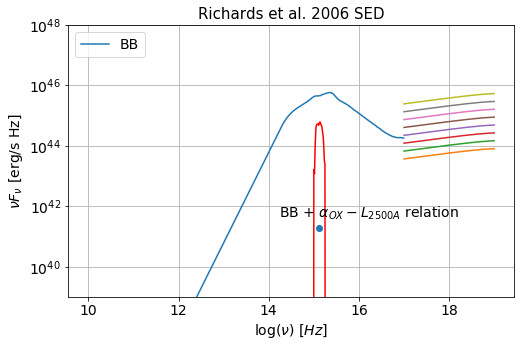

In [95]:
fig = plt.figure(figsize=(8, 5))
bbb_nu = R06dict['wavelength']
bbb_Fnu = R06dict['SED']
plt.semilogy(bbb_nu[bbb_nu < 17], bbb_Fnu[bbb_nu < 17]*10**bbb_nu[bbb_nu < 17], label = 'BB')

sigmas = np.arange(-0.2, 0.55, 0.1)
for i in sigmas:
    xray_nu, xray_Fnu = XRAYS2(bbb_nu, bbb_Fnu, i)
    plt.semilogy(xray_nu, xray_Fnu*10**xray_nu)
#plt.ylim(1e39, 1e48)
nuf, Fnuf = filtering_models(bbb_nu, bbb_Fnu, Galexfilter, 0.1)
plt.scatter(nuf, Fnuf*10**nuf)
nu_GALEX = np.array([np.log10(c/(i*1e-10)) for i in Galex_filter[:,0]][::-1])
plt.semilogy(nu_GALEX, Galex_filter[:,1][::-1]*1e45, 'red')
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.annotate(r'BB + $\alpha_{OX}-L_{2500 A}$ relation', xy=(14, 2*1e41), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=14,  rotation = 0)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.ylim(1e39, 1e48)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.legend(fontsize = 14, loc = 2)
plt.show()
